Minimal example of RelaxedBernoulli not working with AutoHierarchicalNormalMessenger guide:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoHierarchicalNormalMessenger, AutoNormal
from pyro.infer.autoguide.initialization import init_to_value
from pyro.infer import SVI, config_enumerate, Trace_ELBO, infer_discrete, TraceEnum_ELBO

In [2]:
def generate_data(n_components = 2, n_observations = 100, ps = 0.9):
    
    mus = torch.tensor((4., 4.))
    activation = pyro.sample('Bernoulli',
                             dist.Bernoulli(probs = ps).expand([n_observations]).to_event(1))
                             
    mean = mus[0] + mus[1]*activation 
    
    data = pyro.sample("data_target", dist.Normal(loc = mean, scale = 1.))
    
    return activation, mus, data

tensor([4., 4.])
tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 0., 1.,

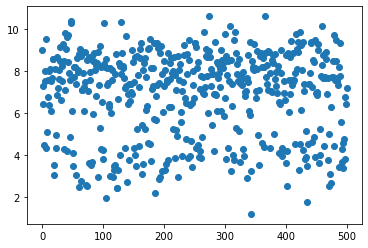

In [3]:
n_components = 2
n_observations = 500
ps = 0.75
activation, mus, data = generate_data(n_components, n_observations, ps)
print(mus)
print(activation)
print(torch.sum(activation)/len(activation))
plt.scatter(range(len(data)), data)

In [4]:
def model_1(data, n_components, n_observations, temp = 1.):
    
    ps = pyro.sample('ps', dist.Dirichlet(torch.ones(n_components)/10.))
    mus = pyro.sample('mus', dist.Gamma(20,2).expand([n_components]).to_event(1))
    activation = pyro.sample('Bernoulli',
                             dist.RelaxedBernoulliStraightThrough(probs = ps[0],
                                                                  temperature = torch.tensor(temp)).expand([n_observations]).to_event(1))                    
    
    mean = mus[0] + mus[1]*activation 
    
    pyro.sample("data_target", dist.Normal(loc = mean, scale = torch.tensor(1.)).to_event(1), obs = data)

AutoNormal guide works fine:

In [5]:
from pyro.infer import Predictive
temperature_array = np.array((1., 10**(-9)))
iterations_array = np.array((50, 1000))

score = np.zeros((len(temperature_array), len(iterations_array)))

for k in range(len(temperature_array)):
    for j in range(len(iterations_array)):
        
        print(temperature_array[k])
        print(iterations_array[j])
        
        # Make appropriate auto guide (and hiding discrete variable)
        global_guide = AutoNormal(model_1)

        # Train model:
        n_iterations = iterations_array[j]
        optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
        elbo = Trace_ELBO(max_plate_nesting=3)
        svi = SVI(model_1, global_guide, optim, loss=elbo)
        for i in range(n_iterations):
            loss = svi.step(data, n_components, n_observations, temp = temperature_array[k])

        posterior = Predictive(model_1, guide=global_guide, num_samples=2)(data, n_components, n_observations)

        score[k,j] = torch.sum(torch.abs(torch.mean(posterior['Bernoulli'], axis = 0) - activation))/len(activation)
        
        del global_guide, svi, optim, posterior

1.0
50
1.0
1000
1e-09
50
1e-09
1000


AutoHierarchicalNormalMessenger does not work:

In [6]:
from pyro.infer import Predictive
temperature_array = np.array((1.,  10**(-9)))
iterations_array = np.array((50, 1000))

score = np.zeros((len(temperature_array), len(iterations_array)))

for k in range(len(temperature_array)):
    for j in range(len(iterations_array)):
        
        print(temperature_array[k])
        print(iterations_array[j])
        
        # Make appropriate auto guide (and hiding discrete variable)
        global_guide = AutoHierarchicalNormalMessenger(model_1)

        # Train model:
        n_iterations = iterations_array[j]
        optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
        elbo = Trace_ELBO(max_plate_nesting=3)
        svi = SVI(model_1, global_guide, optim, loss=elbo)
        for i in range(n_iterations):
            loss = svi.step(data, n_components, n_observations, temp = temperature_array[k])

        posterior = Predictive(model_1, guide=global_guide, num_samples=2)(data, n_components, n_observations)

        score[k,j] = torch.sum(torch.abs(torch.mean(posterior['Bernoulli'], axis = 0) - activation))/len(activation)
        
        del global_guide, svi, optim, posterior

1.0
50


NotImplementedError: 